In [1]:
import MeCab
import pickle
import os
import re
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import pandas as pd
from sklearn.decomposition import TruncatedSVD
import mojimoji

## エピソードの情報のマスターデータを作成

In [25]:
episode_master = {}

post_files_dir = './../shirokane-kougyou.github.io/_posts/'
post_files_path = [os.path.join(post_files_dir, file_name) for file_name in os.listdir(post_files_dir)]

for file_path in sorted(post_files_path):
    print(file_path)
    if file_path.endswith('.md'):
        with open(file_path) as f:
            for i, line in enumerate(f):
                #ファイル名を取得
                filename_pattern = '/audio/(.*).mp3'
                filename_pattern_result = re.search(filename_pattern, line)
                if filename_pattern_result:
                    filename = filename_pattern_result.group(1)
                    # urlも一緒に作成
                    url = 'https://shirokane-kougyou.fm/episode/{}'.format(int(filename))
                #タイトル名を取得
                titile_pattern = 'title: (.*)'
                title_pattern_result = re.search(titile_pattern, line)
                if title_pattern_result:
                    titlename = title_pattern_result.group(1)
                #説明文を取得
                desc_pattern = 'description: (.*)'
                desc_pattern_result = re.search(desc_pattern, line)
                if desc_pattern_result:
                    desc = desc_pattern_result.group(1)
                #音源の長さを取得
                duration_pattern = 'duration: (.*)'
                duration_pattern_result = re.search(duration_pattern, line)
                if duration_pattern_result:
                    duration = duration_pattern_result.group(1)
            episode_master[filename] = {'title': titlename, 'url': url, 'description': desc, 'duration': duration}

# 保存
with open('./data/episode_master.pickle', 'wb') as f:
    pickle.dump(episode_master,f)

./../shirokane-kougyou.github.io/_posts/.DS_Store
./../shirokane-kougyou.github.io/_posts/2019-09-05-1.md
./../shirokane-kougyou.github.io/_posts/2019-10-10-2.md
./../shirokane-kougyou.github.io/_posts/2019-10-21-3.md
./../shirokane-kougyou.github.io/_posts/2019-10-30-4.md
./../shirokane-kougyou.github.io/_posts/2019-11-29-5.md
./../shirokane-kougyou.github.io/_posts/2019-12-13-6.md
./../shirokane-kougyou.github.io/_posts/2019-12-19-7.md
./../shirokane-kougyou.github.io/_posts/2019-12-21-8.md
./../shirokane-kougyou.github.io/_posts/2019-12-25-9.md
./../shirokane-kougyou.github.io/_posts/2019-12-31-10.md
./../shirokane-kougyou.github.io/_posts/2020-01-16-11.md
./../shirokane-kougyou.github.io/_posts/2020-02-08-12.md
./../shirokane-kougyou.github.io/_posts/2020-02-08-13.md
./../shirokane-kougyou.github.io/_posts/2020-02-08-14.md
./../shirokane-kougyou.github.io/_posts/2020-02-13-15.md
./../shirokane-kougyou.github.io/_posts/2020-02-24-16.md
./../shirokane-kougyou.github.io/_posts/2020-03

## エピソード間類似度の計算

In [45]:
def clean_text(text):
  try:
    text = mojimoji.zen_to_han(text, kana=False) # カタカナ以外（英数字）全角→半角変換
    text = text.lower() # 小文字化
    text = re.sub("\t", "", text) #タブの削除
    text = re.sub(re.compile('<.*?>'), '', text) # htmlタグの削除
    text = re.sub(r"https?://[\w/:%#\$&\?\(\)~\.=\+\-]+", "", text) # URLの削除
    text = re.sub("…|\.\.\.", "", text) # 三点リーダの削除
    text = re.sub(r"(\d+年)?(\d+月)?(\d+日)?","",text) # 年月日の削除
    text = re.sub(r"\d+時\d+分|\d+:\d+", "", text) #時刻表示の削除
    text = re.sub(r"[\d一二三四五六七八九十壱弐参拾百千万萬億兆〇]+(円|ドル|人|%|℃|張|万|億|倍|個|つ|件|歳|才|回|本|次|杯|枚|組|台|階)+", "", text)
    text = re.sub(r"[\d一二三四五六七八九十壱弐参拾百千万萬億兆〇]+(秒|分|時間|日|週間|月|か月|ヵ月|カ月|ヶ月|ケ月|年|年代|周年)+", "", text)
    text = re.sub(r"[\d一二三四五六七八九十壱弐参拾百千万萬億兆〇]+(ミリメートル|センチメートル|メートル|キロメートル|キロ|インチ|フィート|ヤード|マイル|海里|寸|尺|里)+","",text) #長さの単位削除
    text = re.sub(r"[\d一二三四五六七八九十壱弐参拾百千万萬億兆〇]+(nm|mm|cm|m|km|in|ft|yd)+","",text) #長さの単位削除
    text = re.sub(r"[\d一二三四五六七八九十壱弐参拾百千万萬億兆〇]+(mg|g|kg|t)+","",text) #重さの単位削除
    text = re.sub(r"[\d一二三四五六七八九十壱弐参拾百千万萬億兆〇]+(フェムトグラム|ピコグラム|ナノグラム|マイクログラム|ミリグラム|グラム|キログラム|トン|グレーン|ドラム|オンス|ポンド|クォーター)+","",text) #重さの単位削除
    text = re.sub(r'[\(]{0,1}[0-9]{2,4}[\)\-\(]{0,1}[0-9]{2,4}[\)\-]{0,1}[0-9]{3,4}', '', text)
    text = re.sub(r"\n", "", text) #改行の削除
    text = re.sub("[\u25A0-\u25FF〇]", " ", text) # 幾何学模様の削除
    text = re.sub("・|\?|¥|!|:|\/|※", "", text) #その他記号を削除
    text = re.sub("[〜~－―]", "-", text) # チルダ・全角ハイフンの置換
    text = re.sub("\(|\)|<|>|\[|\]|\{|\}|【|】|〔|〕|《|》|（|）|「|」|『|』","",text) # さまざまな括弧を削除
    text = re.sub(r"\d+", "", text) #ここまでで消えなかった数値の削除
    text = re.sub(r" ", "", text) #半角スペースの削除
    return text
  except ValueError:
    return (text)

stop_words = ['音', '化', '井上', 'お願い', 'こと', '今日', 'それ', 'ところ', 'みたい', '話','的','人','何','自分','方','感じ','みんな','私','僕','今','時',
            '中','後','気','番','誰','風','結局', '技術','確か','そうそう','前','白金','鉱業','工業','最近','他','一番','好き','名前','データ','データサイエンティスト',
            '会社','分析','会','回','人たち','ブレインパッド','毎回','逆','内容','俺','じゃなくて','住所','人','一','あなた','データサイエンス', '一緒', '吉田', '十',
            '二','ソレ', '我々', '二つ', '今回', '上', '普通', '訳', 'たくさん', 'めちゃくちゃ', 'そうだ', '全部', '五', '八','百','側','一つ','さっき', '年',
            'うんそう','三', '目', '一', '四', '五','六','七','八','九','彼','コミュニティ','係','それぞれ','皆さん','お客さん','か月','非常','城中','上中','白銀',
            'お客様','千','大変','昔','データー','お話し','ないじゃないですか','系','キャレット', '個', '部分','形','問題','僕ら','当時','質問','一個','有村', '最適',
            '先生', 'あそこ', '干支', '点', '割', '大体', '育ち', '性', '高柳', '西場', '別', '色', 'テスト', '本当']

def get_token(text, stop_words=stop_words):
  #tokens = []
  words = []
  mecab = MeCab.Tagger ('-d /opt/homebrew/lib/mecab/dic/mecab-ipadic-neologd')
  node = mecab.parseToNode(text)
  target_part = ['名詞', '固有名詞'] # 名詞と固有名詞のみ抽出
  while node:
    if node.feature.split(",")[0] in target_part:
      if node.surface not in stop_words: # stop_wordsは除外する
        if not re.search(r'^[あ-ん]{1,2}$|\d+|^[a-z]$', node.surface): # ひらがな1~2文字の単語も除外
          words.append(node.surface)
    node = node.next
  #tokens.append(' '.join(words)) #スペース区切りで単語を詰める
  #return tokens[0]
  return words

#df['clean_text'] = df['transcribed_text'].apply(clean_text)

def WordCount(token_list, min_count = 2):
    #tokenizeされた単語リストをinputして、単語の出現回数をカウントした辞書を返す
    #そのときに出現回数が2回以下のものは除外する
    word_freq_dict = Counter(token_list) #各単語の出現回数をカウントして辞書に格納
    word_freq_dict_ch = {word:freq for word,freq in word_freq_dict.items() if freq > min_count}
    return word_freq_dict_ch

def MakeWordcloud(text, file_name):
    # tokenize
    token_list = get_token(text)
    # 単語の出現回数をカウント
    word_freq_dict = WordCount(token_list)

    wordcloud = WordCloud(
        background_color="white",
        max_words = 500,
        max_font_size=140,
        random_state=2019,
        width=900,
        height=500,
        font_path="~/Library/Fonts/RictyDiminished-Bold.ttf",
        stopwords=set(stop_words),
        )
    wordcloud.generate_from_frequencies(word_freq_dict)
    #plt.title(file_name)
    #plt.imshow(wordcloud)

    # 画像を保存
    new_dir_path = './wordcloud_figs'
    os.makedirs(new_dir_path, exist_ok=True)
    output_path = "./wordcloud_figs/{}.png".format(file_name)
    wordcloud.to_file(output_path)

## Amazon Transcribeで作成した文字起こしテキストから種々の情報を抽出・作成

In [46]:
episode = {} # 1話ごとのデータをdictで格納
transcribed_texts = [] # 全話のデータをlistで格納

# 音声文字起こし済みのテキストデータが格納された以下フォルダをDLし、フォルダ名を指定
# https://github.com/ysdyt/podcast_app/tree/master/transcribed_file
transcribed_files_dir = './../podcast_app/transcribed_file/'
transcribed_files_path = [os.path.join(transcribed_files_dir, file_name) for file_name in os.listdir(transcribed_files_dir)]
for file_path in sorted(transcribed_files_path):
    if file_path.endswith('.pickle'):
        #print (file_path)
        episode_id = os.path.splitext(os.path.basename(file_path))[0]
        with open(file_path, 'rb') as f:
            transcribed_result = pickle.load(f)
            text = transcribed_result['results']['transcripts'][0]['transcript']
            episode['episode_id'] = episode_id
            episode['transcribed_text'] = text
            #episode['clean_text'] = clean_text(text)
            episode['token'] = get_token(clean_text(text))
            #episode['char_len'] = len(text)
            #episode['clean_char_len'] = len(clean_text(text))
            #episode['token_len'] = len(get_token(clean_text(text)))
            transcribed_texts.append(episode.copy())

            ## ついでにwordcloudも作成
            MakeWordcloud(text, episode_id)

#確認
print(len(transcribed_texts))

53


In [32]:
# TfidfVectorizerに入れてtf-idfを計算するために、全文書を一つのlistに格納
list_tokens = []
for i in transcribed_texts:
    list_tokens.append(' '.join(i['token'])) #スペース区切りにして、listに格納


#list_tokens = [i['token'] for i['token'] in transcribed_texts]
#list_tokens = [token[0] for token in df_pj['tokens']]

# 確認
#print(len(list_tokens))
#print(list_tokens[1])

In [33]:
def tfidf_vec(list_tokens):
  # tf-idfの計算
  vectorizer = TfidfVectorizer(
    max_df=0.5, # 全文書の50%の文書で出現する単語は無視
    min_df=5, # 全文書で5回しか出現しない単語は無視
    max_features=1280, #TF値の高い単語上位x個のみを計算対象とする
    token_pattern=r"(?u)\b\w+\b" # デフォルトでは1文字は計算対象外になるが、1文字も対象とする
  )
  tfidf_fit = vectorizer.fit(list_tokens)
  tfidf_transform = vectorizer.transform(list_tokens)

  print(tfidf_transform.shape)
  return tfidf_transform

tfidf_transform = tfidf_vec(list_tokens)

(53, 1280)


In [34]:
def reduce_dim(vecs):
  lsa = TruncatedSVD(n_components=128, random_state=0) #componentsの数に次元を圧縮
  lsa_fit = lsa.fit(tfidf_transform)
  lsa_transform = lsa.transform(tfidf_transform)
  return lsa_transform

lsa_transform = reduce_dim(tfidf_transform)

# 指定した次元数になっているか確認
print(lsa_transform.shape)

(53, 53)


In [35]:
from sklearn.metrics.pairwise import cosine_similarity

cos_sim = cosine_similarity(lsa_transform, lsa_transform)
print(cos_sim.shape)

(53, 53)


In [36]:
sim_episode = {}
sim_episodes = []
results = {}

for idx,x in enumerate(cos_sim):
    target_episode = transcribed_texts[idx]['episode_id']
    #print('idx',idx, transcribed_texts[idx]['file_name'])
    #print(transcribed_texts[idx]['file_name'], episode_master[transcribed_texts[idx]['file_name']])
    desc_order_idx = np.argsort(x)[::-1] #cos類似度が高い順にソート
    for order_idx in desc_order_idx:
        if transcribed_texts[order_idx]['episode_id'] != transcribed_texts[idx]['episode_id']: #自分自身は除外
            sim_episode['cos_sim'] = x[order_idx]
            sim_episode['episode_id'] = transcribed_texts[order_idx]['episode_id']
            sim_episode['title'] = episode_master[transcribed_texts[order_idx]['episode_id']]['title']
            sim_episode['url'] = 'https://shirokane-kougyou.fm/episode/{}'.format(int(transcribed_texts[order_idx]['episode_id']))
            sim_episodes.append(sim_episode.copy())
    results[target_episode] = sim_episodes
    sim_episodes = []

with open('./output/cossim_result.pickle', 'wb') as f:
    pickle.dump(results,f)


In [44]:
for idx, result in enumerate(results['001'][:5]):
    print('【類似度{}位】'.format(idx+1))
    print('コサイン類似度: {:.4f}'.format(result['cos_sim']))
    print('タイトル: {}'.format(result['title']))
    print(result['url'])
    print(result['episode_id'])

【類似度1位】
コサイン類似度: 0.3838
タイトル: 10. B2Bのデータサイエンティスト部署露出のためにこの1年でやってきたこと
https://shirokane-kougyou.fm/episode/10
010
【類似度2位】
コサイン類似度: 0.2835
タイトル: 4. 白金鉱業/dgtalk/d3m 主催者で語る「なんで勉強会運営やってるの？」
https://shirokane-kougyou.fm/episode/4
004
【類似度3位】
コサイン類似度: 0.2462
タイトル: 27. 特別ゲスト @nyker_gotoさん
https://shirokane-kougyou.fm/episode/27
027
【類似度4位】
コサイン類似度: 0.2364
タイトル: 8. 特別企画『ブレインパッドDS質問会』（後編）
https://shirokane-kougyou.fm/episode/8
008
【類似度5位】
コサイン類似度: 0.2323
タイトル: 2. エンタメとAI
https://shirokane-kougyou.fm/episode/2
002


In [10]:
# for idx,x in enumerate(cos_sim):
#     desc_order_idx = np.argsort(x)[::-1] #cos類似度が高い順にソート
#     #print('idx',idx, transcribed_texts[idx]['file_name'])
#     print(transcribed_texts[idx]['file_name'], episode_master[transcribed_texts[idx]['file_name']])
#     for order_idx in desc_order_idx:
#         if transcribed_texts[order_idx]['file_name'] != transcribed_texts[idx]['file_name']: #自分自身は除外
#             #print(order_idx)
#             #print(transcribed_texts[order_idx]['file_name'])
#             print(x[order_idx], transcribed_texts[order_idx]['file_name'], episode_master[transcribed_texts[order_idx]['file_name']])
#     print('=======================')

001 1. 白金鉱業 Meetup一年間やってみてどうでした？
0.38628653065469676 010 10. B2Bのデータサイエンティスト部署露出のためにこの1年でやってきたこと
0.2854871495777321 004 4. 白金鉱業/dgtalk/d3m 主催者で語る「なんで勉強会運営やってるの？」
0.25123614934803334 027 27. 特別ゲスト @nyker_gotoさん
0.23984109785692118 002 2. エンタメとAI
0.23649922863087974 008 8. 特別企画『ブレインパッドDS質問会』（後編）
0.2339324475869944 005 5. 意思決定とデータサイエンス
0.23140130081953508 022 22. 新卒n年目が終わる
0.22550678714399292 041 41. 特別ゲスト 草野社長（後編）
0.22315299458486243 007 7. 特別企画『ブレインパッドDS質問会』（前編）
0.21583962261973225 053 53. タカヤナギ=サン＆西場さんとよろずトーク！
0.21153911847324883 030 30. フルリモート時代の新卒研修運営
0.20874320319111792 051 51. リモート時代でも勉強会が盛んな組織を作る「b2b」の紹介
0.2086774641120026 011 11. 受託分析業における常駐分析 Case.2
0.204442174810852 052 52. もっと語りたい『事業立ち上げにデータサイエンティストは必要なのか？』
0.2026743629822276 009 9. 受託分析業における常駐分析
0.18572355561129283 050 50. 『にのひらさん、BPやめるってよ』
0.17878458006305045 037 37. 将棋AI入門
0.17727912438786594 006 6. Chief Data Technology Officer（CDTO）って何をする役職ですか？
0.17442500831749386 048 48. 分析PM Seven Questions WITH Haruyuki Tsuji
0.1703235

## cos類似度が一定以上のエピソードでネットワークを作る

In [40]:
source_list = []
target_list = []
cos_sim_list = []

for idx,x in enumerate(cos_sim):
    desc_order_idx = np.argsort(x)[::-1] #降順にソート
    for order_idx in desc_order_idx:
        if transcribed_texts[order_idx]['episode_id'] != transcribed_texts[idx]['episode_id']: #自分自身は除外
            if x[order_idx] > 0.25: #cos類似度が0.25以上のもののみ
                source_list.append(episode_master[transcribed_texts[idx]['episode_id']]['title']) #主体エピソード
                target_list.append(episode_master[transcribed_texts[order_idx]['episode_id']]['title']) #類似エピソード
                cos_sim_list.append(x[order_idx]) #cos類似度

edges = pd.DataFrame({'source': source_list, 'target': target_list, 'weight': cos_sim_list})

#確認
edges


,source,target,weight
0,1. 白金鉱業 Meetup一年間やってみてどうでした？,10. B2Bのデータサイエンティスト部署露出のためにこの1年でやってきたこと,0.383819
1,1. 白金鉱業 Meetup一年間やってみてどうでした？,4. 白金鉱業/dgtalk/d3m 主催者で語る「なんで勉強会運営やってるの？」,0.283541
2,3. ノーベル物理学賞と天文学,16. 物理勢と楽しむ機械学習イベントの振り返り,0.255451
3,4. 白金鉱業/dgtalk/d3m 主催者で語る「なんで勉強会運営やってるの？」,51. リモート時代でも勉強会が盛んな組織を作る「b2b」の紹介,0.459274
4,4. 白金鉱業/dgtalk/d3m 主催者で語る「なんで勉強会運営やってるの？」,27. 特別ゲスト @nyker_gotoさん,0.284414
5,4. 白金鉱業/dgtalk/d3m 主催者で語る「なんで勉強会運営やってるの？」,1. 白金鉱業 Meetup一年間やってみてどうでした？,0.283541
6,4. 白金鉱業/dgtalk/d3m 主催者で語る「なんで勉強会運営やってるの？」,10. B2Bのデータサイエンティスト部署露出のためにこの1年でやってきたこと,0.271273
7,5. 意思決定とデータサイエンス,53. タカヤナギ=サン＆西場さんとよろずトーク！,0.297705
8,5. 意思決定とデータサイエンス,7. 特別企画『ブレインパッドDS質問会』（前編）,0.255448
9,5. 意思決定とデータサイエンス,41. 特別ゲスト 草野社長（後編）,0.255259


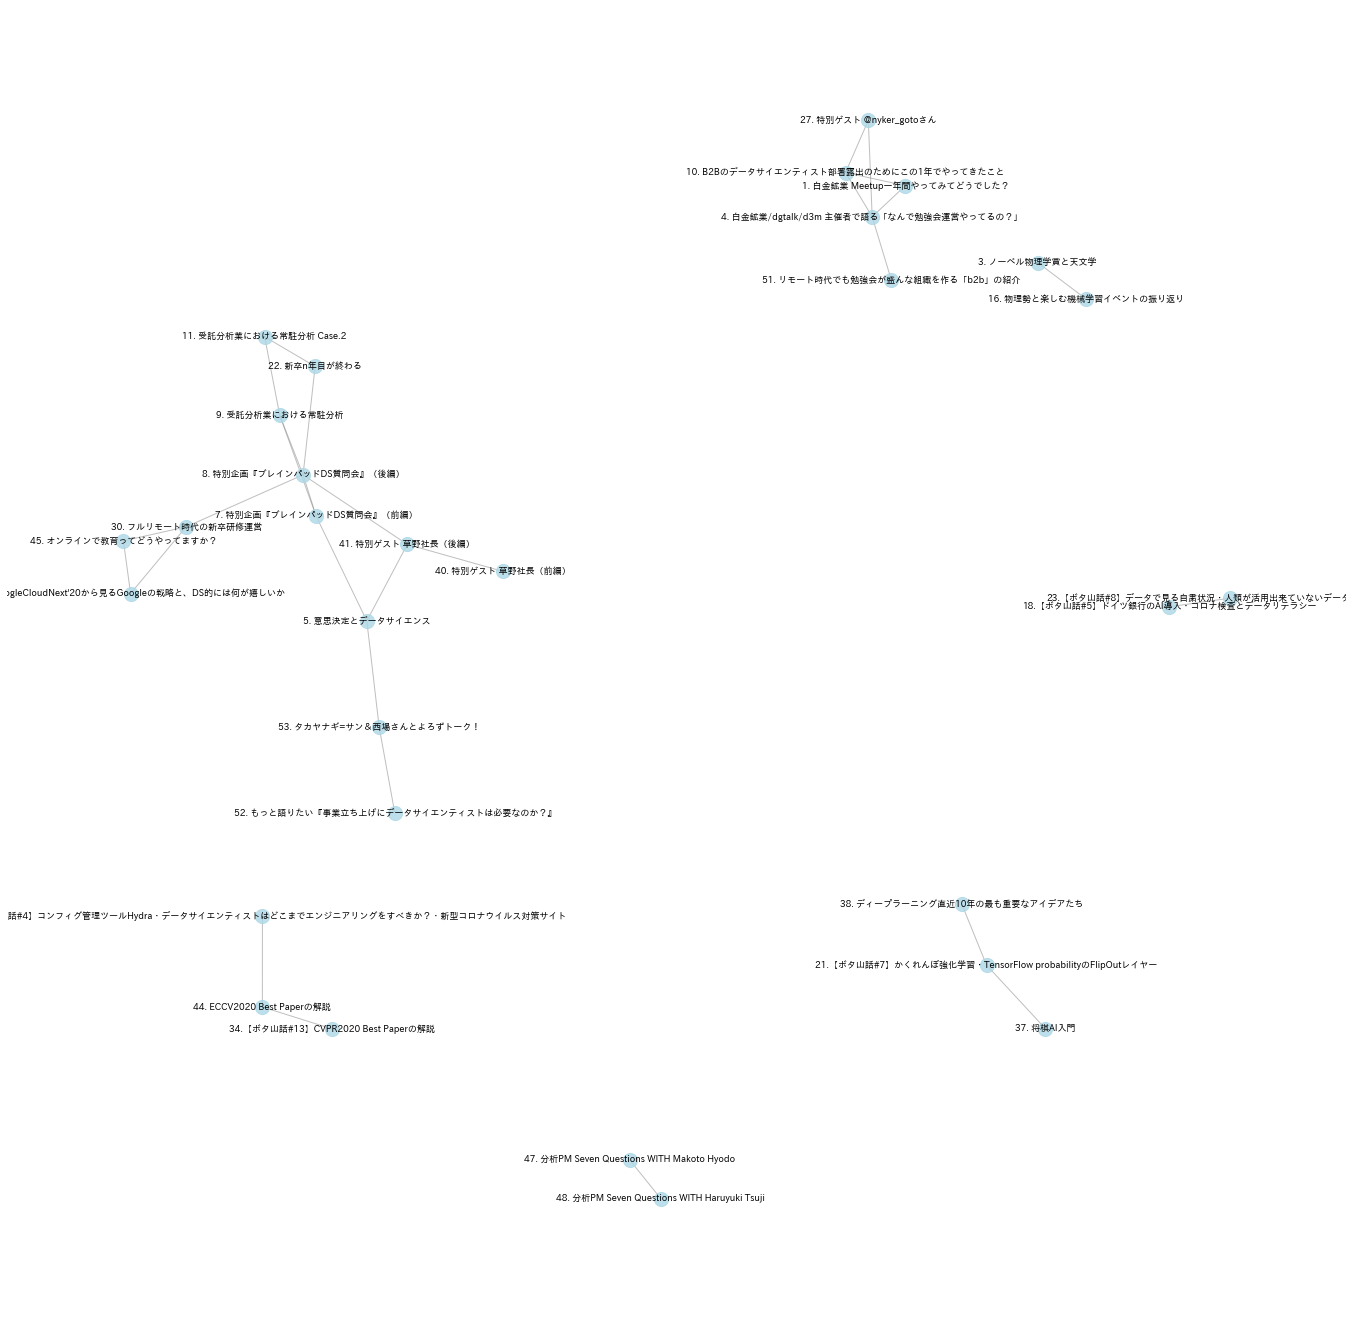

In [41]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import rcParams
import japanize_matplotlib
rcParams['font.family'] = 'IPAexGothic'
from pyvis.network import Network


G = nx.from_pandas_edgelist(edges,edge_attr=True,create_using=nx.Graph())

node_size=200
edge_width=1

plt.figure(figsize=(24, 24))
pos = nx.spring_layout(G, seed=0)
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=node_size, alpha=0.8)
nx.draw_networkx_edges(G, pos, width=edge_width, edge_color='gray', alpha=0.5)
nx.draw_networkx_labels(G, pos, font_family='IPAexGothic', font_size=9)
plt.axis('off')
plt.show() #notebook上での確認用

## インタラクティブなグラフを作成し、htmlファイルとして保存
# ブラウザで見やすくするために600x800のちょっと大きめの表示サイズにする。背景黒、文字白の見た目にする
pyvis_G = Network(height='600px', width='800px',bgcolor='#222222',font_color='white')
pyvis_G.from_nx(G)
#pyvis_G.enable_physics(True)  #html上でレイアウト動かしたくない場合false

# Generate network with specific layout settings
pyvis_G.repulsion(node_distance=420, central_gravity=0.33,
                    spring_length=110, spring_strength=0.10,
                    damping=0.95)
pyvis_G.show("episode-network_025.html")